In [1]:
import os
os.chdir('/rds/general/user/cb1319/home/GEOM3D/Geom3D/')


In [2]:
from geom3d.test_train import *
import torch
import copy
chkpt_path = os.getcwd()+"/training/SchNet_target_1K_TEST_5e4lr/epoch=2-val_loss=44.51-other_metric=0.00.ckpt"
config_dir = os.getcwd()+"/training/SchNet_target_1K_TEST_5e4lr/"

In [3]:
config = read_config(config_dir)
pymodel = Pymodel.load_from_checkpoint(config["pl_model_chkpt"])


config loaded from /rds/general/user/cb1319/home/GEOM3D/Geom3D/training/SchNet_target_1K_TEST_5e4lr/


In [4]:
pymodel.freeze()
config["device"] = "cuda:0" if torch.cuda.is_available() else "cpu"
pymodel.to(config["device"] )
model_embedding = pymodel.molecule_3D_repr

    
np.random.seed(config["seed"])
torch.cuda.manual_seed_all(config["seed"])
dataset = load_data(config)

In [5]:
#find data in dataset with a specific InChI key
df_path = Path(
        config["STK_path"], "data/output/Full_dataset/", config["df_total"]
    )
df_precursors_path = Path(
    config["STK_path"],
    "data/output/Prescursor_data/",
    config["df_precursor"],
)
df_total, df_precursors = Database_utils.load_data_from_file(
    df_path, df_precursors_path
)


In [6]:
# test model inference on a single molecule
data = dataset[:100]
data = [x.to(config["device"]) for x in data]
def predict_targe (data):
    data = Batch.from_data_list(data)
    pymodel.eval()
    with torch.no_grad():
        out = pymodel(data)
    #print('y_pred is ',out)
    #print('y_true is ',data.y)
    L1 = out.squeeze()-data.y
    print('loss is ',L1.abs().mean())
    return out.squeeze(), data.y
def PredictTargetFromEmbedding(data):
    model = pymodel.graph_pred_linear
    model.eval()
    with torch.no_grad():
        out = model(data)
    #print('y_pred is ',out)
    #print('y_true is ',data.y)
    L1 = out.squeeze()-data.y
    print('loss is ',L1.abs().mean())
    return out.squeeze()
predict_targe (data)

loss is  tensor(0.2383, device='cuda:0')


(tensor([ -9.0663,  -8.6410,  -9.1867, -10.6644, -11.5400, -10.1049,  -9.9563,
         -11.0255, -11.1419,  -6.8116, -11.1030, -10.0709,  -9.2115,  -9.9826,
          -7.0804, -10.6445, -10.1636,  -7.5789, -10.0933, -10.1220,  -7.2996,
         -11.0891,  -7.9837, -10.1429, -10.9428, -10.9074, -11.3365,  -5.7997,
          -9.8614, -10.6813,  -9.9489, -11.0592, -10.6687, -10.0657,  -8.9590,
          -9.9143,  -9.6210,  -9.6051, -10.7519,  -8.9600,  -3.4636, -10.2846,
          -8.6257,  -9.9467, -10.5403, -10.8085,  -9.0151, -10.9194,  -9.8521,
         -10.9528, -10.5298, -11.0599, -11.1440,  -9.7348,  -9.6644, -10.2840,
         -11.2253,  -6.8607, -10.9772, -10.1245, -11.1386,  -6.9936, -10.2698,
         -10.5565,  -6.0483, -10.4795, -10.0518, -10.6864,  -7.6856,  -9.1998,
         -11.8467, -11.2139, -11.1132,  -9.4293, -10.7879, -10.9253, -11.2649,
         -10.4964, -10.7622,  -8.6747, -10.4372,  -6.9454,  -9.2726, -10.5919,
         -10.6625, -10.7319, -11.1333, -10.4790,  -9

In [8]:
import numpy as np
import os
import pandas as pd
from geom3d import Database_utils
from botorch.models.gp_regression import SingleTaskGP
from stk_search.tanimoto_kernel import TanimotoKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch import kernels
from stk_search.Search_algorithm import (
    Representation_slatm,
    RepresentationPrecursor,
)
from stk_search.Search_algorithm import Bayesian_Optimisation
from stk_search import Searched_space
from sklearn.decomposition import PCA

import torch
def load_data(df_path = "data/output/Full_datatset/df_total_new2023_08_20.csv",
                df_precursors_path = "data/output/Prescursor_data/calculation_data_precursor_190923_clean.pkl"):
    df_total, df_precursors = Database_utils.load_data_from_file(
        df_path, df_precursors_path
    )
    SP = Searched_space.Searched_Space(
        number_of_fragments=6,
        df=df_precursors,
        features_frag=df_precursors.columns[0:1],
        generation_type="conditional",
    )
    searched_space_df = SP.check_df_for_element_from_SP(df_to_check=df_total)
    fitness_acquired = searched_space_df["target"].values
    searched_space_df_InChIKey = searched_space_df[['InChIKey']]
    searched_space_df = searched_space_df[[f"InChIKey_{x}" for x in range(6)]]
    return df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey

def generate_repr_data(df_path = df_path,
                df_precursors_path = df_precursors_path):
    #loa
    df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey = load_data(df_path,df_precursors_path)



    BO = Bayesian_Optimisation.Bayesian_Optimisation()
    BO.Representation = Representation3D(model_embedding,df_total,data=dataset)
    BO.verbose = True
    X_explored = BO.Representation.generate_repr(searched_space_df)
        # limit the dataframe to only the numeric data
    y_explored = torch.tensor(
        fitness_acquired, dtype=torch.float32, device=BO.device
    )
    return BO, X_explored, y_explored

ModuleNotFoundError: No module named 'stk_search'

In [38]:
#df_total, df_precursors, searched_space_df, fitness_acquired, searched_space_df_InChIKey = load_data(df_path,df_precursors_path)



BO = Bayesian_Optimisation.Bayesian_Optimisation()
BO.Representation = Representation3D(model_embedding,df_total,data=dataset)
BO.verbose = True
BO.device = "cuda:0" if torch.cuda.is_available() else "cpu"
X_explored = BO.Representation.generate_repr(searched_space_df[600:700])
print(X_explored.shape)
y_explored = torch.tensor(
            fitness_acquired[600:X_explored.shape[0]+600], dtype=torch.float32, device=BO.device
        )

No data found in database
No data found in database
No data found in database
torch.Size([97, 128])


In [155]:
test_set_size =0.5
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_scaler,
) = BO.get_test_train_data_for_BO(
    X_explored,
    y_explored[:290].cpu(),
    test_set_size=test_set_size,
)

In [156]:
test_model_dict = []
count = 0
case =""
def normalise_input( X_list: list[torch.tensor]):
    X_all = torch.cat(X_list)
    X_list_norm = []
    for i, X in enumerate(X_list):
        X = X[:, X_all.std(axis=0) != 0]
        X_list_norm.append((X - X_all.mean(axis=0)) / X_all.std(axis=0))
    return X_list_norm
X_train = X_train.type(torch.float64)
X_test = X_test.type(torch.float64)
[X_train,X_test]=normalise_input([X_train, X_test])
data = {
    "X_train": X_train.cpu(),
    "X_test": X_test.cpu(),
    "y_train": y_train,
    "y_test": y_test,
    "y_scaler": y_scaler,
}

In [161]:
X_train[0].cpu()


tensor([-1.9755e-01,  3.7763e-04, -5.3626e-01, -1.6320e+00, -2.2164e-01,
         1.1919e+00, -2.4607e-01, -9.9967e-01,  8.1396e-01,  1.2504e+00,
         5.0978e-01, -6.5459e-01,  6.9360e-01, -8.4009e-01, -9.3684e-01,
         7.9662e-02, -3.5203e-01, -3.0430e-01, -7.8297e-01,  4.4285e-03,
        -1.2724e+00,  2.4232e+00,  4.1408e-01,  2.9808e-01, -1.7001e+00,
        -1.8653e+00,  1.0354e+00, -1.0620e+00,  3.3302e-01,  6.1836e-01,
         1.7866e+00,  3.9537e-01, -9.9195e-01,  7.0746e-01,  1.3212e-01,
         7.1089e-01, -1.3623e-01, -8.6305e-01, -6.0744e-01, -8.7492e-03,
         9.5656e-01, -3.2525e-03, -5.8965e-01, -2.1029e+00,  6.3310e-01,
         7.6304e-01, -4.6104e-01, -9.1583e-01,  1.3072e+00, -8.2772e-01,
         1.1028e-01,  1.7053e-01,  1.7186e+00, -5.9199e-03,  5.4592e-01,
        -1.0351e+00,  6.2261e-01,  1.8955e-01, -2.2585e-01, -1.4842e+00,
        -7.3541e-01,  1.1297e+00, -1.7605e+00,  4.6389e-01, -1.8838e+00,
        -1.0558e+00, -1.2516e+00,  4.8835e-01, -2.1

Training size torch.Size([145, 128])
R2 score: -0.00
MSE score: 0.13
MAE score: 0.28
R2 score: 0.00
MSE score: 0.10
MAE score: 0.25


/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([-0.0364], dtype=torch.float64), std = tensor([0.9419], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


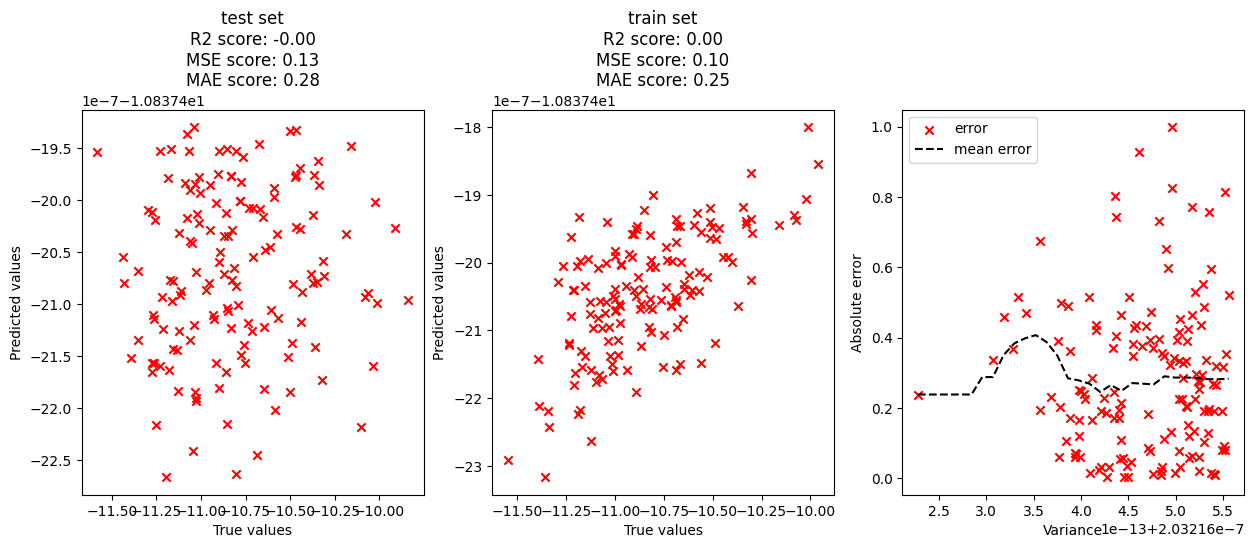

In [ ]:
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import kernels

from stk_search.tanimoto_kernel import TanimotoKernel


# We define our custom GP surrogate model using the Tanimoto kernel
class TanimotoGP(SingleTaskGP):
    def __init__(self, train_X, train_Y):
        super().__init__(train_X, train_Y)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(base_kernel=TanimotoKernel())
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

def run_training_BO_torch(
    BO, test_set_size, data
):
    

    BO.kernel = TanimotoGP

    print("Training size", data["X_train"].shape)
    # %%

    BO.train_model_gpytorch(data["X_train"], y_train, NUM_EPOCHS=1000)
    BO.model.eval()

    with torch.no_grad():
        posterior_train = BO.model.posterior(data["X_train"])
        posterior_test = BO.model.posterior(data["X_test"])

    y_pred = posterior_test.mean.cpu()
    y_pred_train = posterior_train.mean.cpu()
    y_var = posterior_test.variance.cpu()
    y_pred = data['y_scaler'].inverse_transform(y_pred)
    y_pred_train = data['y_scaler'].inverse_transform(y_pred_train)
    y_test = data['y_scaler'].inverse_transform(y_test)
    y_train = data['y_scaler'].inverse_transform(y_train)
    fig_name = (
        f"trainsize_"
        + str(data["X_train"].shape[0])
        + "_testSi_"
        + str(data["X_test"].shape[0])
        + "_kernel_"
        + kernel_name._get_name()
        + "_botorch.png"
    )
    scores_test, scores_train = BO.plot_prediction(
        y_pred,
        y_test_plot,
        y_pred_train,
        y_train_plot,
        y_var,
        save_plot=True,
        plot_name=fig_name,
    )
    return y_pred_train, y_pred

%matplotlib inline
y_pred_train, y_pred = run_training_BO_torch(
                        BO, test_set_size,  data
                    )


In [36]:
"""
this script is to encode the representation of the oligomer from the representation of the fragments
"""
import numpy as np
import torch
from torch_geometric.data import Data, Batch


class Representation3D:
    def __init__(self, model_embedding,df_results, data=None,db_poly=None):
        self.model_embedding = model_embedding
        self.model_embedding.eval()
        self.device = ("cuda" if torch.cuda.is_available() else torch.device("cpu"))

        self.model_embedding.to(self.device)
        self.df_inchikey = None
        self.df_total = df_results
        if data is not None:
            self.dataset = data
        else:
            if self.db_poly is not None:
                self.db_poly = db_poly
            else:
                raise ValueError("Please provide either data or db_poly")
    def generate_repr(self, elements):
        elements_copy = elements.copy()
        elements_copy = elements_copy.values
        InChIKeys = self._find_elem_InchiKey(elements_copy)
        molecules = []
        for x in InChIKeys:
            if self.dataset is not None:
                data = self.find_data(x)
                if data is not None:
                    molecules.append(data)
            else:
                molecules.append(self._getinfo_db(x))
        with torch.no_grad():
            batch = Batch.from_data_list(molecules).to(self.device)
            original_encoding = self.model_embedding(batch.x, batch.positions, batch.batch)
        return original_encoding
    def _getinfo_db(self,InChIKey):
        
        polymer = self.db_poly.get({"InChIKey": InChIKey})
        frags = []
        dat_list = list(polymer.get_atomic_positions())
        positions = np.vstack(dat_list)
        positions = torch.tensor(positions, dtype=torch.float, device=self.device)
        atom_types = list(
            [
                atom.get_atom().get_atomic_number()
                for atom in polymer.get_atom_infos()
            ]
        )
        atom_types = torch.tensor(atom_types, dtype=torch.long, device=self.device)
        molecule = Data(x=atom_types, positions=positions, device=self.device)
        return molecule

    def find_data(self, key):
        for i in range(len(self.dataset)):
            if self.dataset[i]["InChIKey"] == key:
                return self.dataset[i]
        print("No data found in database")
        return None
    def _find_elem_InchiKey(self, elements):
        InChIKeys = []
        if self.df_inchikey is None:
            for elm in elements:
                df_search = self.df_total.copy()
                for i, x in enumerate(elm):
                    df_search = df_search[df_search[f"InChIKey_{i}"] == x]
                InChIKeys.append(df_search['InChIKey'].values.astype(str))
        else:
            InChIKeys = self.df_inchikey['InChIKey'].values.astype(str)
        return InChIKeys

In [50]:
X_explored.shape

torch.Size([5, 128])